In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import viscid
from viscid.plot import vpyplot as vlt
import h5py
import pandas as pd
viscid.calculator.evaluator.enabled = True

%config InlineBackend.figure_format = 'retina'
project_dir = "/Users/kai/src/pppl-project/flatfoil/2stream_001"


my viscid


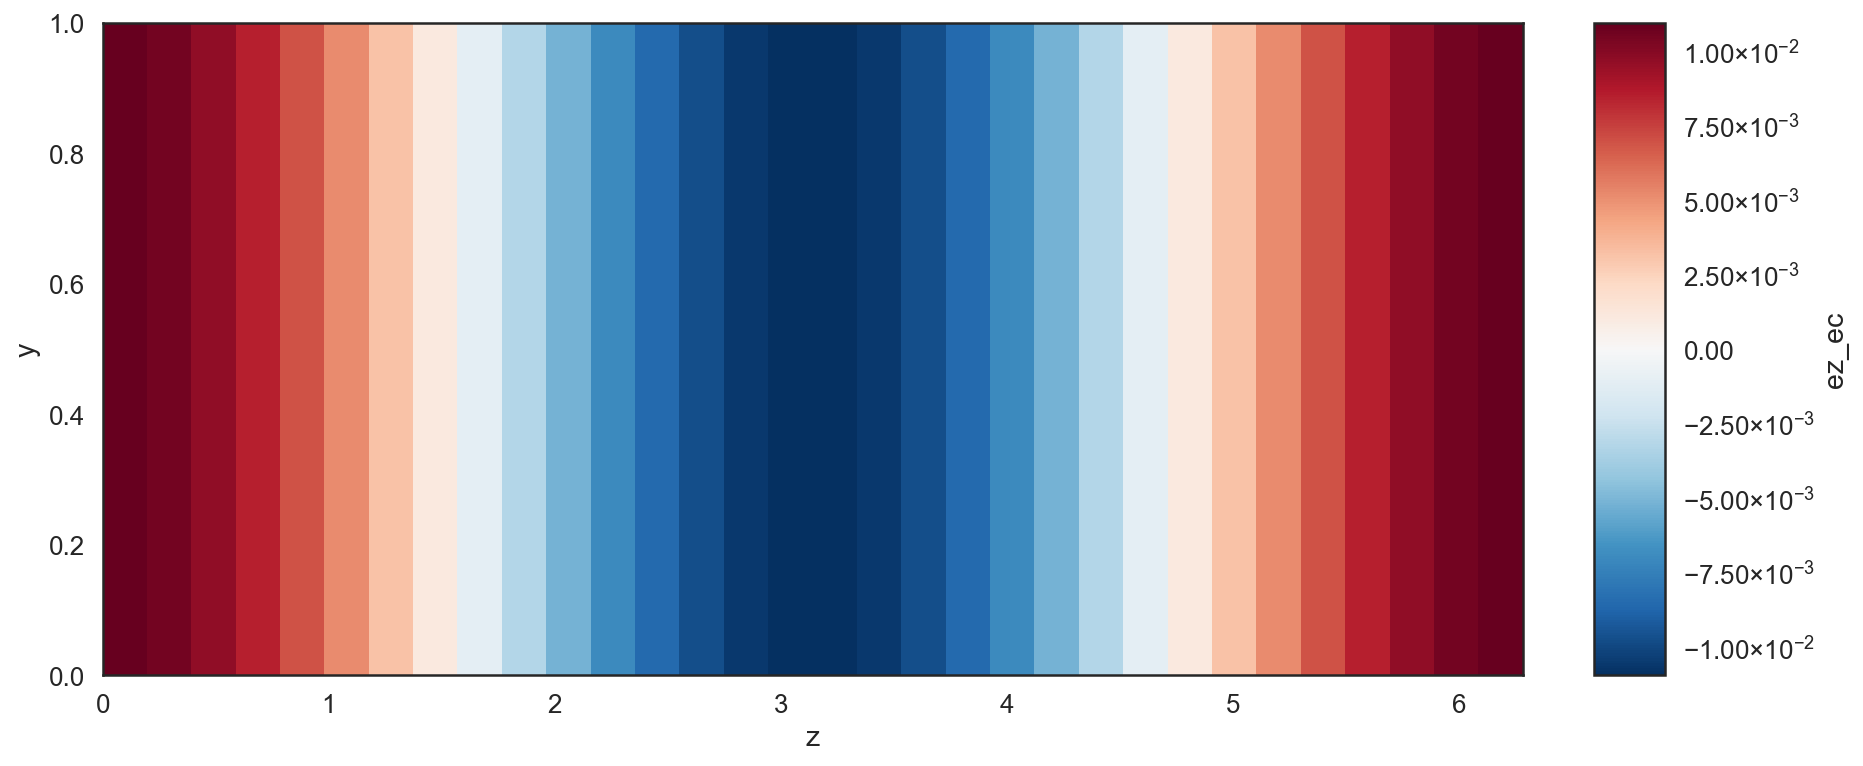

In [4]:
f = viscid.load_file(project_dir + "/pfd.xdmf", force_reload=True)
f.activate_time(0)
plt.figure(figsize=(14,6))
vlt.plot(f["ez_ec"].T);


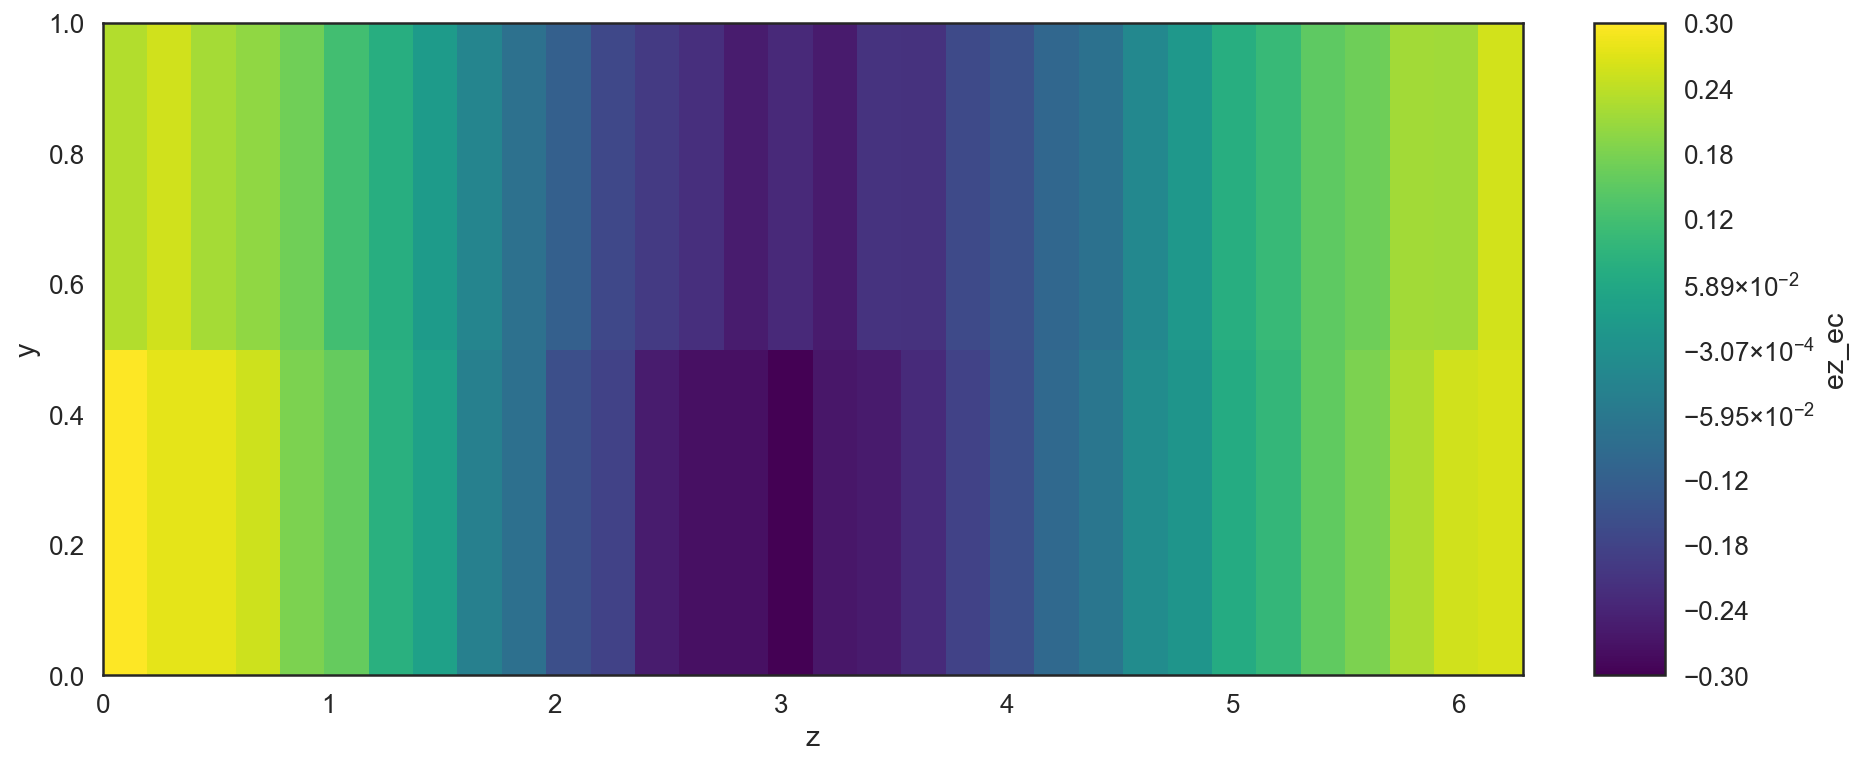

In [7]:
f.activate_time(1)
plt.figure(figsize=(14,6))
vlt.plot(f["ez_ec"].T);


In [3]:
class ParticleReader(object):
    def __init__(self, filename):
        file = h5py.File(filename, "r")
        self._particles = file["particles/p0/1d"]
        self._idx_begin = file["particles/p0/idx_begin"]
        self._idx_end = file["particles/p0/idx_end"]
        self.selection_lo = file["particles"].attrs["lo"]
        self.selection_hi = file["particles"].attrs["hi"]
        self.gdims = np.array(self._idx_begin.shape[3:0:-1])
        self.n_kinds = self._idx_begin.shape[0]
        
    def size(self):
        return self._particles.shape[0]
        
    def inCell(self, kind, idx):
        loc = (kind, idx[2] - selection_lo[2], idx[1] - selection_lo[1], idx[0] - selection_lo[0])
        return slice(self._idx_begin[loc], self._idx_end[loc])
    
    def __getitem__(self, idx):
        if isinstance(idx, slice) or isinstance(idx, int):
            return self._particles[idx]
        elif isinstance(idx, tuple):
            return self._particleSelection(idx)
        else:
            raise "don't know how to handle this index"
            
    def _particleSelection(self, idx):
        indices = self._indices(idx)
        n = np.sum(indices[:,1] - indices[:,0])
        prts = np.zeros(n, dtype=self._particles[0].dtype)
        cnt = 0
        for r in indices:
            l = int(r[1] - r[0])
            prts[cnt:cnt+l] = self._particles[r[0]:r[1]]
            cnt += l
        return pd.DataFrame(prts)
    
    def _indices(self, idx_):
        # reorder index
        idx = (idx_[0], idx_[3], idx_[2], idx_[1])
        begin = self._idx_begin[idx].flatten()
        end = self._idx_end[idx].flatten()
        indices = [sl for sl in zip(begin, end)]
        indices = np.sort(indices, axis=0)
        # this index range could be merged where contiguous, or maybe even where
        # not contiguous but close
        return indices
        
    def __repr__(self):
        return ("ParticleReader(n={} gdims={} n_kinds={} selection=({}, {})"
                .format(self.size(), self.gdims, self.n_kinds, self.selection_lo, self.selection_hi))

In [4]:
pr = ParticleReader(project_dir + "/prt.000100_p000000.h5")
df = pd.DataFrame(pr[:])
df.head()

,x,y,z,px,py,pz,q,m,w,id,tag
0,0.0,0.000146,0.128001,0.0,-0.000184,0.100241,-1.0,1.0,1.0,0,0
1,0.0,0.000121,0.130753,0.0,-0.000183,0.100205,-1.0,1.0,1.0,0,0
2,0.0,0.000120,0.133395,0.0,-0.000179,0.100143,-1.0,1.0,1.0,0,0
3,0.0,0.000030,0.151726,0.0,-0.000179,0.100103,-1.0,1.0,1.0,0,0
4,0.0,0.000028,0.155210,0.0,-0.000175,0.100140,-1.0,1.0,1.0,0,0


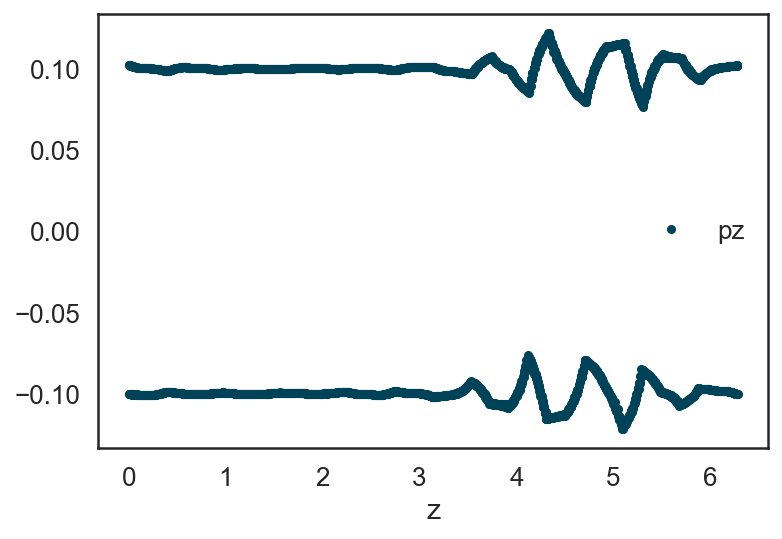

In [5]:
df.plot("z", "pz", style='.')